In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy as scp
from scipy import optimize
from scipy import special
from scipy import stats
from scipy.stats import invgauss
from itertools import product
import xarray 
import warnings
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings('ignore')

np.random.seed(250197)
def sample(func,params,rate):
    searching = True
    time = 0
    while searching:
        nextPassage = func(**params)
        nextRate = np.random.exponential(1/rate)
        if nextRate>nextPassage:
            searching = False
            time += nextPassage
        else:
            time += nextRate
    return time

def sharpSample(func,params,rate):
    searching = True
    time = 0
    nextRate = round(1/rate)
    while searching:
        nextPassage = func(**params)
        if nextRate>nextPassage:
            searching = False
            time += nextPassage
        else:
            time += nextRate
    return time

def pade3_2(x,U0,U1,D1,U2,D2,D3):
    return (U2*x**2+x*U1+U0)/(D3*x**3+D2*x**2+x*D1+1)

def pade3_3(x,U0,D0,U1,D1,U2,D2,U3,D3,D4):
    return (U3*x**3+U2*x**2+x*U1+U0)/(D3*x**3+D2*x**2+x*D1+D0)

def pade3_4(x,A,U1,D1,U2,D2,U3,D3,D4):
    return (U3*x**3+U2*x**2+x*U1+A)/(D4*x**4+D3*x**3+D2*x**2+x*D1+A)

def IGLaplace(rs,L,D,V):
    return np.exp(L/(2*D)*(V-np.sqrt(V**2+4*D*rs)))

def forwardExpansion(x,x0,delta,vals):

    first = (-49/20*vals[0] + 6*vals[1] -15/2*vals[2] + 20/3*vals[3] -15/4*vals[4] + 6/5*vals[5] -1/6*vals[6])/delta
    second = (469/90*vals[0] -223/10*vals[1] +879/20*vals[2] -949/18*vals[3] +41*vals[4] -201/10*vals[5] +1019/180*vals[6]-7/10*vals[7])/(delta**2)
    third = (-801/80*vals[0] +349/6*vals[1] -18353/120*vals[2] +2391/10*vals[3] -1457/6*vals[4] +4891/30*vals[5] -561/8*vals[6]+527/30*vals[7]-469/240*vals[8])/(delta**3)
    fourth = (1069/80*vals[0] -1316/15*vals[1] +15289/60*vals[2] -2144/5*vals[3] +10993/24*vals[4] -4772/15*vals[5] +2803/20*vals[6]-536/15*vals[7]+967/240 *vals[8])/(delta**4)
    
    return vals[0] + first*(x-x0) + second*(x-x0)**2/2 + third*(x-x0)**3/6 + fourth*(x-x0)**4/24

def GammaLaplace(rs,k,theta):
    return (1+rs*theta)**(-k)

def FrechetLaplace(rs,**kwargs):
    return 2*np.sqrt(rs)*scp.special.kn(1,2*np.sqrt(rs))
fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
# plt.style.use('default')
plt.style.use('seaborn-colorblind')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle
plt.rc("savefig", dpi=200)

Plot predictions...

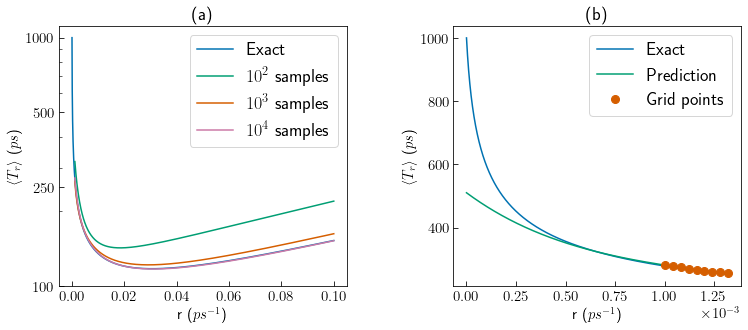

In [2]:
# Set parameters
mu = 1000000
CV = 5
D = 0.5*mu*CV**2
m = 2*D/mu
s = mu/m

# plot exact mean FPT vs r
fig, axs = plt.subplots(1,2,figsize=(12,6))            
fig.tight_layout(pad=5.0)
rs = np.linspace(0.000000,0.0001,10000)
Trs = IGLaplace(rs,mu,D,1)
mus = (1-Trs)/(rs*Trs)
mus[0] = mu
axs[0].plot(rs*1000,mus/1000,label="Exact")

# plot predicted mean FPT vs r
rate = 0.000001
rs = np.linspace(rate,0.0001,1000)
for size,name in zip([100,1000,10000],[r"$10^2$",r"$10^3$",r"$10^4$"]):
    samples = np.array([sample(invgauss.rvs,dict(mu=m,scale=s),rate) for i in range(size)])
    Trs = np.array([sum(np.exp(-r*samples))/len(samples) for r in (rs-rate)])
    mus = (1-Trs)/((rs-rate)*Trs)
    axs[0].plot(rs*1000,mus/1000,label=f"{name} samples")
    
# Arrange plot a
axs[0].legend()
axs[0].set_xlabel(r"r ($ps^{-1}$)")
axs[0].set_ylabel(r"$\langle T_r \rangle$ ($ps$)")
axs[0].set_yscale("log")
axs[0].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_yticks([100,250,500,1000])
axs[0].set_title("(a)")

# plot exact mean FPT vs r
dr = 25
rs = np.linspace(0,rate+8*rate/dr,10000)
Trs = IGLaplace(rs,mu,D,1)
mus = (1-Trs)/(rs*Trs)
mus[0] = 1e6
axs[1].plot(rs*1000,mus/1000,label="Exact")

# plot predicted mean FPT vs r
selrs = np.linspace(rate,rate+8*rate/dr,9)
selTrs = np.array([sum(np.exp(-r*samples))/len(samples) for r in (selrs-rate)])
selmus = (1-selTrs)/((selrs-rate)*selTrs)
selmus[0] = samples.mean()
pres = forwardExpansion(rs,rate,rate/dr,selmus)
axs[1].plot(rs*1000,pres/1000,label="Prediction")
axs[1].plot(selrs*1000,selmus/1000,"o",label="Grid points",markersize=8)

# Arrange plot b
axs[1].set_xlabel(r"r ($ps^{-1}$)")
axs[1].set_ylabel(r"$\langle T_r \rangle$ ($ps$)")
axs[1].legend()
axs[1].set_title("(b)")
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
# plt.savefig("analyticPredictionAndExtrapolation.png")

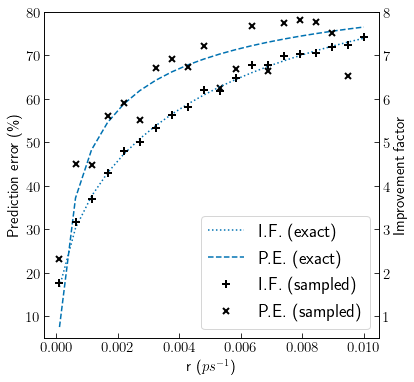

In [3]:
# plot analytical improvement vs r
rs = np.linspace(0.0000001,0.00001,20)
Trs = IGLaplace(rs,mu,D,1)
mus = (1-Trs)/(rs*Trs)
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax2 = ax.twinx()
lns1 = ax2.plot(rs*1000,mu/mus,linestyle="dotted",label="I.F. (exact)")
ax2.set_ylim(0.5,8)
ax2.set_ylabel("Improvement factor")

# plot analytical error vs r
predictions = []
for rate in rs:
    selrs = np.linspace(rate,rate+8*rate/dr,9)
    selTrs = IGLaplace(selrs,mu,D,1)
    selmus = (1-selTrs)/(selrs*selTrs)
    predictions.append(forwardExpansion(0,rate,rate/dr,selmus))
predictions = np.array(predictions)
errors = 100*abs(mu-predictions)/mu
lns2 = ax.plot(rs*1000,errors,linestyle="dashed",label="P.E. (exact)")

# plot simulated
improvements = []
errors = []
for rate in rs:
    samples = np.array([sample(invgauss.rvs,dict(mu=m,scale=s),rate) for i in range(10000)])
    improvements.append(mu/samples.mean())
    selrs = np.linspace(rate,rate+8*rate/dr,9)
    selTrs = np.array([sum(np.exp(-r*samples))/len(samples) for r in (selrs-rate)])
    selmus = (1-selTrs)/((selrs-rate)*selTrs)
    selmus[0] = samples.mean()
    pres = forwardExpansion(0,rate,rate/dr,selmus)
    errors.append(100*abs(mu-pres)/mu)
lns3 = ax2.plot(rs*1000,improvements,"+",label="I.F. (sampled)",c="black",mew=2,ms=8)
lns4 = ax.plot(rs*1000,errors,"x",label="P.E. (sampled)",c="black",mew=2)

# Arrange plot
ax.set_ylim(5,80)
ax.set_ylabel("Prediction error (\%)")
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax.legend(lns,labs,loc="lower right")
ax.set_xlabel(r"r ($ps^{-1}$)")
# plt.savefig("tradeoff.png")

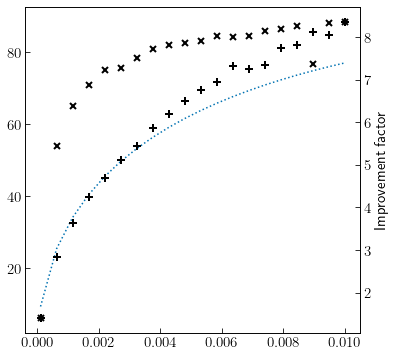

In [12]:
# plot analytical improvement vs r
rs = np.linspace(0.0000001,0.00001,20)
Trs = IGLaplace(rs,mu,D,1)
mus = (1-Trs)/(rs*Trs)
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax2 = ax.twinx()
lns1 = ax2.plot(rs*1000,mu/mus,linestyle="dotted",label="I.F. (exact)")
# ax2.set_ylim(0.5,8)
ax2.set_ylabel("Improvement factor")
improvements = []
errors = []
for rate in rs:
    samples = np.array([sharpSample(invgauss.rvs,dict(mu=m,scale=s),rate) for i in range(10000)])
    improvements.append(mu/samples.mean())
    selrs = np.linspace(rate,rate+8*rate/dr,9)
    selTrs = np.array([sum(np.exp(-r*samples))/len(samples) for r in (selrs-rate)])
    selmus = (1-selTrs)/((selrs-rate)*selTrs)
    selmus[0] = samples.mean()
    pres = forwardExpansion(0,rate,rate/dr,selmus)
    errors.append(100*abs(mu-pres)/mu)
lns3 = ax2.plot(rs*1000,improvements,"+",label="I.F. (sampled)",c="black",mew=2,ms=8)
lns4 = ax.plot(rs*1000,errors,"x",label="P.E. (sampled)",c="black",mew=2)

Text(135.80294780802458, 0.5, 'y ($\\AA$)')

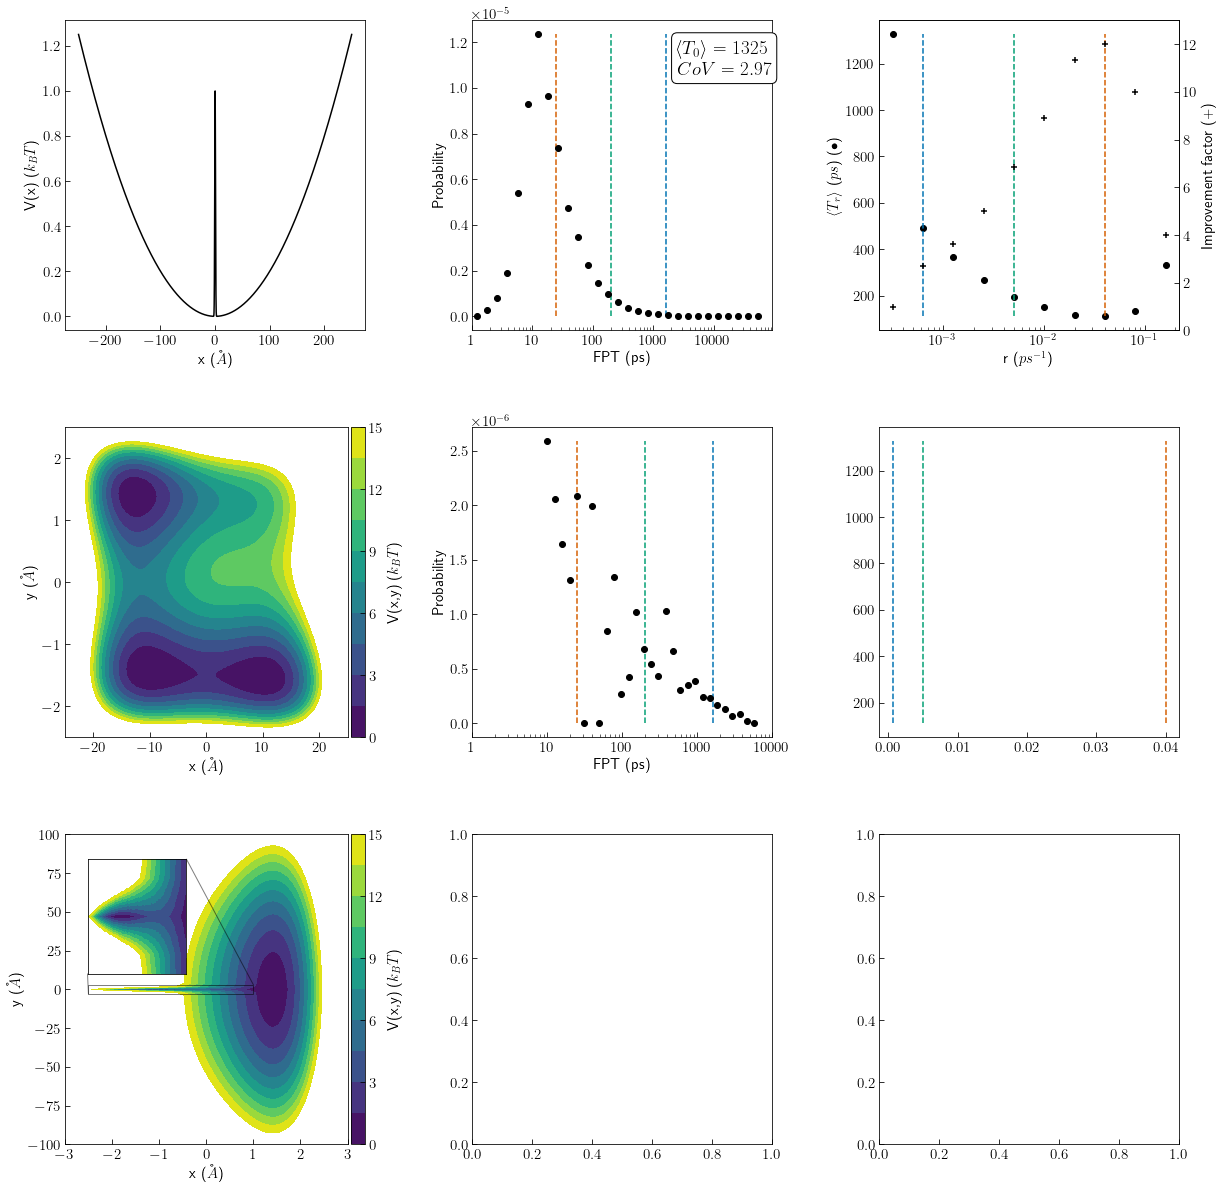

In [15]:
# plot 1D potential
fig, axs = plt.subplots(3,3,figsize=(18,18))
fig.tight_layout(pad=5.0)
A = 0.59616/50000
B = 0.59616
C = 1
x = np.linspace(-250,250,10000)
V = A*x**2 + B*np.exp(-C*x**2)
axs[0][0].plot(x,(V-V.min())/0.59616,c="black",label="Potential")
axs[0][0].set_xlabel(r"x ($\AA$)")
axs[0][0].set_ylabel(r"V(x) ($k_BT$)")

# make 1D fpt array
rates = [0.,0.000625,0.00125,0.0025,0.005,0.01,0.02,0.04,0.08,0.16]
fpts = []
cfpts = []
for rate in rates:
    fpts.append(np.loadtxt(f"results/FPT1Drate{str(rate).split('.')[-1]}",skiprows=1).mean())
    try:
        cfpts.append(np.loadtxt(f"results/cFPT1Drate{str(rate).split('.')[-1]}",skiprows=1).mean())
    except:
        pass
fpts = np.array(fpts)
cfpts = np.array(cfpts)
unbiased = np.loadtxt(f"results/FPT1Drate0",skiprows=1)

# plot selected rates
logbins = np.logspace(np.log10(unbiased.min()-1000),np.log10(unbiased.max()),30)
xs = 0.5*(logbins[1:] + logbins[:-1])
c,b = np.histogram(unbiased, bins=logbins, density=True)
for i in range(1,len(rates),3):
    axs[0][1].plot([1/rates[i],1/rates[i]],[0,c.max()],linestyle="dashed")
    axs[0][2].plot([rates[i],rates[i]],[fpts.min()/1000,fpts.max()/1000],linestyle="dashed")

# plot 1D fpt histogram
axs[0][1].plot(xs/1e3,c,"o",c="black")
axs[0][1].set_xscale("log")
axs[0][1].set_ylabel("Probability")
axs[0][1].set_xlabel("FPT (ps)")
axs[0][1].set_xlim(1)
axs[0][1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0][1].set_xticks([1,10,100,1000,10000])

props = dict(boxstyle='round', facecolor='white')
axs[0][1].text(2500,1.06e-5,fr"$\langle T_0 \rangle = {int(fpts[0]/1000)}$" + "\n" +fr"$CoV = {format(unbiased.std()/unbiased.mean(),'.2f')}$",fontsize=19,bbox=props)

# plot 1D mean fpt and improvement against r
ax12 = axs[0][2].twinx()
# axs[0][2].scatter(rates,fpts/1000,c="black")
axs[0][2].scatter(rates[1:],cfpts/1000,c="black")
# ax12.scatter(rates,fpts[0]/fpts,marker="+",c="black")
ax12.scatter(rates[1:],fpts[0]/cfpts,marker="+",c="black")
axs[0][2].scatter(0.0003125,fpts[0]/1000,c="black")
ax12.scatter(0.0003125,1,marker="+",c="black")
ax12.set_ylabel("Improvement factor (+)")
axs[0][2].set_ylabel(r"$\langle T_r \rangle$ ($ps$) ($\bullet$)")
axs[0][2].set_xlabel(r"r ($ps^{-1}$)")
axs[0][2].set_xscale("log")
ax12.set_ylim(0,13)

# plot Wolfe Quapp potential
pointsx = np.linspace(-25,25,100)
pointsy = np.linspace(-2.5,2.5,100)
xs = []
ys = []
Vs = []
levels = np.linspace(0,15,11)
for xt in pointsx:
    x = xt/10
    for yt in pointsy:
        y = yt/1
        Vs.append(1.5*0.59616*(x**4+y**4-2*x**2-4*y**2+x*y+1.5*x+1.2*y))
        xs.append(xt)
        ys.append(yt)

surface = pd.DataFrame({"x":xs,"y":ys,"V":Vs})
surface.V -= surface.V.min() 
im = axs[1][0].tricontourf(surface.x,surface.y,surface.V/0.59616,levels=levels)
divider = make_axes_locatable(axs[1][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=f"V(x,y) ($k_BT$)")
axs[1][0].set_xlabel(r"x ($\AA$)")
axs[1][0].set_ylabel(r"y ($\AA$)")

unbiased = np.loadtxt(f"results/FPTWQrate0",skiprows=1)

# plot selected rates
logbins = np.logspace(np.log10(unbiased.min()-1000),np.log10(unbiased.max()),30)
xs = 0.5*(logbins[1:] + logbins[:-1])
c,b = np.histogram(unbiased, bins=logbins, density=True)
for i in range(1,len(rates),3):
    axs[1][1].plot([1/rates[i],1/rates[i]],[0,c.max()],linestyle="dashed")
    axs[1][2].plot([rates[i],rates[i]],[fpts.min()/1000,fpts.max()/1000],linestyle="dashed")

# plot Wolfe Quapp fpt histogram
axs[1][1].plot(xs/1e3,c,"o",c="black")
axs[1][1].set_xscale("log")
axs[1][1].set_ylabel("Probability")
axs[1][1].set_xlabel("FPT (ps)")
axs[1][1].set_xlim(1)
axs[1][1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[1][1].set_xticks([1,10,100,1000,10000])

# plot Gaussians potential
pointsy = np.linspace(-100,100,101)
pointsx = np.linspace(-3,3,100)
xs = []
ys = []
Vs = []
A = [25,25]
alphas = [1.3,1.3]
lambdas = [1000,1]
x0s = [2.5,-2.5]
y0s = [0,0]
levels = np.linspace(0,15,11)
for x in pointsx:
    for y in pointsy:
        W_1 = A[0]*np.exp(-(x-x0s[0])**2/(2*alphas[0]**2)-(y-y0s[0])**2/(2*lambdas[0]**2))
        W_2 = A[1]*np.exp(-(x-x0s[1])**2/(2*alphas[1]**2)-(y-y0s[1])**2/(2*lambdas[1]**2))
        Vs.append((-(W_1 + W_2) + 4*x**2 + 0.001*y**2))
        xs.append(x)
        ys.append(y)
surface = pd.DataFrame({"x":xs,"y":ys,"V":Vs})
surface.V -= surface.V.min() 
axs[2][0].tricontourf(surface.x,surface.y,surface.V/0.59616,levels=levels)
axins = axs[2][0].inset_axes([0.08, 0.55, 0.35, 0.37])
axins.tricontourf(surface.x,surface.y,surface.V/0.59616,levels=levels)
axins.set_xlim(-2.5, 1)
axins.set_ylim(-3, 3)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.xaxis.set_ticks_position('none') 
axins.yaxis.set_ticks_position('none') 
axs[2][0].indicate_inset_zoom(axins, edgecolor="black")
divider = make_axes_locatable(axs[2][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=f"V(x,y) ($k_BT$)")
axs[2][0].set_xlabel(r"x ($\AA$)")
axs[2][0].set_ylabel(r"y ($\AA$)")

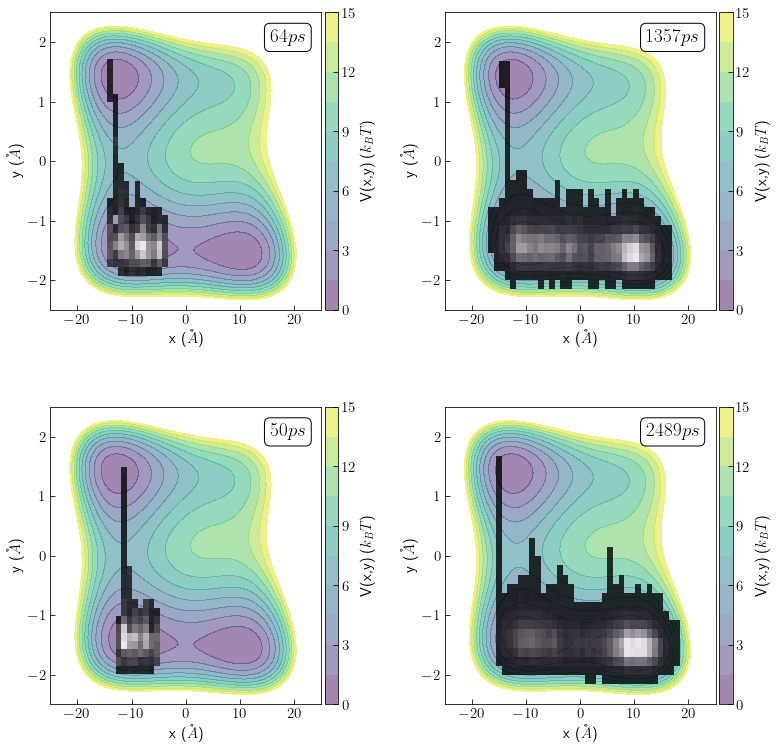

In [376]:
fig, axs = plt.subplots(2,2,figsize=(12,12))
fig.tight_layout(pad=5.0)

axs = axs.flatten()
pointsx = np.linspace(-25,25,100)
pointsy = np.linspace(-2.5,2.5,100)
xs = []
ys = []
Vs = []
levels = np.linspace(0,15,11)
for xt in pointsx:
    x = xt/10
    for yt in pointsy:
        y = yt/1
        Vs.append(1.5*0.59616*(x**4+y**4-2*x**2-4*y**2+x*y+1.5*x+1.2*y))
        xs.append(xt)
        ys.append(yt)

surface = pd.DataFrame({"x":xs,"y":ys,"V":Vs})
surface.V -= surface.V.min() 
for ax in axs:
    im = ax.tricontourf(surface.x,surface.y,surface.V/0.59616,levels=levels,alpha=0.5)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical',label=f"V(x,y) ($k_BT$)")
    ax.set_xlabel(r"x ($\AA$)")
    ax.set_ylabel(r"y ($\AA$)")
subplot = 0
for seed in [10000,10001,10004,10008]:
    with open(f"../LAMMPS/trajectories/dump{seed}.xyz","r") as file:
        lines = file.readlines()
    xs = []
    ys = []
    for i in range(2,len(lines),3):
        xs.append(float(lines[i].split()[1]))
        ys.append(float(lines[i].split()[2]))
    H, xedges, yedges = np.histogram2d(xs, ys, bins=(int((max(xs)-min(xs))),25))
    H = H.T
    H[H==0] = None
    axs[subplot].imshow(H, interpolation='nearest',aspect="auto", origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap='gray',zorder=10,alpha=0.8)
    axs[subplot].set_xlim(-25,25)
    axs[subplot].set_ylim(-2.5,2.5)
    FPT = int(len(xs)/100)
    axs[subplot].text(19-len(str(FPT))*1.7,2,fr"${FPT} ps$",fontsize=19,bbox=props)
    subplot += 1

array([-0.75, -0.75, -0.75, -0.75, -0.75, -0.75, -0.75, -0.75, -0.75,
       -0.75, -1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  ,
       -1.  , -1.  , -1.25, -1.25, -1.25, -1.25, -1.25, -1.25, -1.25,
       -1.25, -1.25, -1.25, -1.5 , -1.5 , -1.5 , -1.5 , -1.5 , -1.5 ,
       -1.5 , -1.5 , -1.5 , -1.5 , -1.75, -1.75, -1.75, -1.75, -1.75,
       -1.75, -1.75, -1.75, -1.75, -1.75, -2.  , -2.  , -2.  , -2.  ,
       -2.  , -2.  , -2.  , -2.  , -2.  , -2.  ])

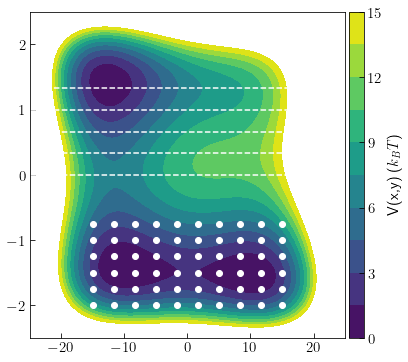

In [42]:
fig, ax = plt.subplots(figsize=(6,6))

pointsx = np.linspace(-25,25,100)
pointsy = np.linspace(-2.5,2.5,100)
xs = []
ys = []
Vs = []
levels = np.linspace(0,15,11)
for xt in pointsx:
    x = xt/10
    for yt in pointsy:
        y = yt/1
        Vs.append(1.5*0.59616*(x**4+y**4-2*x**2-4*y**2+x*y+1.5*x+1.2*y))
        xs.append(xt)
        ys.append(yt)

surface = pd.DataFrame({"x":xs,"y":ys,"V":Vs})
surface.V -= surface.V.min() 
im = ax.tricontourf(surface.x,surface.y,surface.V/0.59616,levels=levels)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=f"V(x,y) ($k_BT$)")
x = np.linspace(-15, 15, 10)
y = np.linspace(-0.75,-2, 6)
X,Y = np.meshgrid(x,y)
ax.scatter(X,Y,c="white")
for y in [0,0.33,0.66,1,1.33]:
    ax.plot([-25,25],[y,y],c="white",linestyle="dashed")
Y.flatten()

(6.592847523387758, 16116000.0)

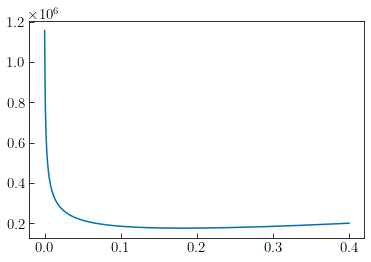

In [17]:
rs = np.linspace(0.0,0.0004,2000)
fpts = np.loadtxt("results/FPTWQrate0",skiprows=1)
fpts = np.loadtxt("results/FPT2Grate0",skiprows=1)
Trs = np.array([sum(np.exp(-r*fpts))/len(fpts) for r in rs])
mus = (1-Trs)/(rs*Trs)
mus[0] = fpts.mean()
plt.plot(rs*1000,mus)
# plt.yscale("log")
mus[0]/mus.min(), fpts.max()

In [10]:
dat = pd.DataFrame({"t":np.linspace(0,9999,10000),"fpt":fpts})
dat.loc[dat.fpt==50000000]

,t,fpt
891,891.0,50000000.0
940,940.0,50000000.0
5049,5049.0,50000000.0
7722,7722.0,50000000.0
9286,9286.0,50000000.0
9465,9465.0,50000000.0


,x,y,V
3226,-1.060606,-1.424242,0.0


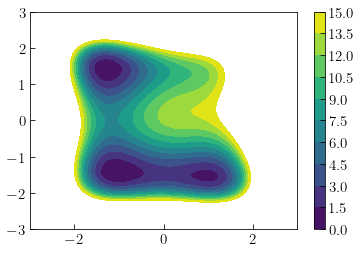

In [22]:
pointsx = np.linspace(-3,3,100)
pointsy = np.linspace(-3,3,100)
xs = []
ys = []
Vs = []
levels = np.linspace(0,15,11)
for xt in pointsx:
    x = xt/1
    for yt in pointsy:
        y = yt/1.
        Vs.append(1.75*0.59616*(x**4+y**4-2.*x**2-4*y**2+1.*x*y+1.75*x+1.2*y))
        xs.append(xt)
        ys.append(yt)

surface = pd.DataFrame({"x":xs,"y":ys,"V":Vs})
surface.V -= surface.V.min() 
surface.V = surface.V/0.59616
plt.tricontourf(surface.x,surface.y,surface.V,levels=levels)
cbar = plt.colorbar(ticks=levels)
V = surface.loc[surface.y<0]
V.loc[V.V==V.V.min()]

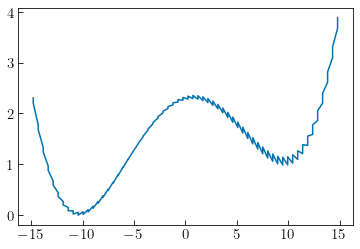

In [7]:
V = surface.loc[surface.y>-2].loc[surface.y<2].loc[surface.x>-1.1].loc[surface.x<-1]
# plt.plot(V.y,V.V)
V = surface.loc[surface.y<-1.4].loc[surface.y>-1.5].loc[surface.x>-15].loc[surface.x<15]
plt.plot(V.x,V.V)

# surface.loc[surface.V==0]

,x,y,V
7221,1.30303,0.0,1.776357e-15


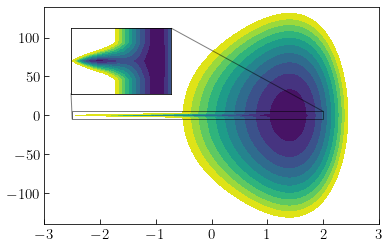

In [80]:
pointsy = np.linspace(-140,140,101)
pointsx = np.linspace(-3,3,100)
xs = []
ys = []
Vs = []
A = [24.5,24.5]
alphas = [1.3,1.3]
lambdas = [2000,1]
x0s = [2.5,-2.5]
y0s = [0,0]

levels = np.linspace(0,15,11)
for x in pointsx:
    for y in pointsy:
        W_1 = A[0]*np.exp(-(x-x0s[0])**2/(2*alphas[0]**2)-(y-y0s[0])**2/(2*lambdas[0]**2))
        W_2 = A[1]*np.exp(-(x-x0s[1])**2/(2*alphas[1]**2)-(y-y0s[1])**2/(2*lambdas[1]**2))
        Vs.append((-(W_1 + W_2) + 4*x**2 + 0.0005*y**2))
        xs.append(x)
        ys.append(y)

surface = pd.DataFrame({"x":xs,"y":ys,"V":Vs})
surface.V -= surface.V.min() 
fig, ax = plt.subplots()
axins = ax.inset_axes([0.08, 0.6, 0.3, 0.3])
ax.tricontourf(surface.x,surface.y,surface.V/0.59616,levels=levels)
axins.tricontourf(surface.x,surface.y,surface.V/0.59616,levels=levels)
axins.set_xlim(-2.5, 2)
axins.set_ylim(-5, 5)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.xaxis.set_ticks_position('none') 
axins.yaxis.set_ticks_position('none') 
ax.indicate_inset_zoom(axins, edgecolor="black")

# lim = -1
right = surface.loc[surface.x>0]
right.loc[right.V==right.V.min()]
# plt.plot([lim,lim],[-5,5],linestyle="dashed",c="white")